# Least Squares Minimum Norm

Let $A \in R^{n, p}$ and $b \in R^n$. The least squares problem is defined as
$$x^\star = argmin_{x \in R^p} ||Ax - b||_2^2$$

In the case of singular matrices $A$ or unterdetermined matrices, $n < p$, the above is not precisely defined and permits many solutions $x^\star$. In those cases, a more precise defintion is the **minimum norm least squares** solution
$$x^\star = argmin_{x \in R^p} ||x||_2 \quad \text{subject to}\quad min_{x \in R^p} ||Ax - b||_2^2$$

Good concise reference:</br>
- Do Q Lee (2012), Numerically Efficient Methods For Solving Least Squares Problems</br>
  http://math.uchicago.edu/~may/REU2012/REUPapers/Lee.pdf</br>
- Also a good source wrt OLS is</br>
  https://arxiv.org/abs/1903.08560

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from scipy.stats import ortho_group
from scipy import linalg
from scipy.sparse import linalg as spla


def generate_U_S_Vt(n=10, p=5, random_state=532):
    """Generate SVD to construct a regular matrix A.
    
    A has n rows, p columns.
    
    Returns
    -------
    U: orthogonal matrix
    S: diagonal matrix
    Vt: orthogonal matrix
    """
    r = min(n, p)
    S = np.diag(1.0 * np.arange(1, 1 + r))
    if n > p:
        # add rows with value 0
        S = np.concatenate((S, np.zeros((n - p, p))), axis=0)
    elif p > n:
        # add columns with value 0
        S = np.concatenate((S, np.zeros((n, p - n))), axis=1)
    U = ortho_group.rvs(n, random_state=random_state)
    Vt = ortho_group.rvs(p, random_state=random_state + 1)
    return U, S, Vt


def solve_least_squares(A, b):
    """Solve least squares with several methods.
    
    Returns
    ------
    x : dictionary with solver and solution
    """
    x = {}
    x["gelsd"] = linalg.lstsq(A, b, lapack_driver="gelsd")[0]
    x["gelsy"] = linalg.lstsq(A, b, lapack_driver="gelsy")[0]
    x["lsqr"] = spla.lsqr(A, b)[0]
    x["lsmr"] = spla.lsmr(A, b)[0]
    x["normal_eq"] = linalg.solve(A.T @ A, A.T @ b, assume_a="sym")

    return x


def print_dict(d):
    np.set_string_function(np.array2string)
    pprint(d)
    np.set_string_function(None)
        
        
np.set_printoptions(precision=5)

## Overdetermined Problems

### Regular (Non-Singular) System

In [2]:
n = 10
p = 5

U, S, Vt = generate_U_S_Vt(n=n, p=p)
A = U @ S @ Vt

x_true = np.round(6 * Vt.T[:p, 0])  # interesting choice
rng = np.random.default_rng(157)
noise = rng.standard_normal(n)
b = A @ x_true + noise

S_inv = np.copy(S.T)
S_inv[S_inv>0] = 1/S_inv[S_inv>0]

x_exact = Vt.T @ S_inv @ U.T @ b

print(f"x_exact = {x_exact}")
print_dict(solve_least_squares(A, b))

x_exact = [ 0.78087 -4.74942 -0.99938 -2.38327 -3.7431 ]
{'gelsd': [ 0.78087 -4.74942 -0.99938 -2.38327 -3.7431 ],
 'gelsy': [ 0.78087 -4.74942 -0.99938 -2.38327 -3.7431 ],
 'lsmr': [ 0.78087 -4.74942 -0.99938 -2.38327 -3.7431 ],
 'lsqr': [ 0.78087 -4.74942 -0.99938 -2.38327 -3.7431 ],
 'normal_eq': [ 0.78087 -4.74942 -0.99938 -2.38327 -3.7431 ]}


In [3]:
norm(A @ x_exact - b)

2.1991578596425243

### Singular System
We set the first singular value of `A_sing` to zero. `A_sing` is has rank $r = p - 1 = 4$.

In [4]:
S[0, 0] = 0
A = U @ S @ Vt

S_inv = np.copy(S.T)
S_inv[S_inv>0] = 1/S_inv[S_inv>0]

# Minimum Norm Solution
x_exact = Vt.T @ S_inv @ U.T @ b

print(f"x_exact = {x_exact}")
x_solution = solve_least_squares(A, b)
print_dict(x_solution)

x_exact = [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ]
{'gelsd': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'gelsy': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'lsmr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'lsqr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'normal_eq': [-0.08393 -0.60784  0.17531 -0.57127 -0.50437]}


/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/ipykernel_launcher.py:46: LinAlgWarning: Ill-conditioned matrix (rcond=3.30641e-17): result may not be accurate.


In [5]:
print(f"norm of x:\n"
      f"x_exact:   {norm(x_exact)}\n"
      f"normal_eq: {norm(x_solution['normal_eq'])}\n"
     )
print(f"norm of Ax-b:\n"
      f"x_exact:   {norm(A @ x_exact - b)}\n"
      f"normal_eq: {norm(A @ x_solution['normal_eq'] - b)}"
     )

norm of x:
x_exact:   0.5092520023062155
normal_eq: 0.993975690303498

norm of Ax-b:
x_exact:   6.9594032092014935
normal_eq: 6.9594032092014935


In [6]:
# Warning stems from this
linalg.solve(A.T @ A, A.T @ b, assume_a='sym')

/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/ipykernel_launcher.py:2: LinAlgWarning: Ill-conditioned matrix (rcond=3.30641e-17): result may not be accurate.
  


array([-0.08393, -0.60784,  0.17531, -0.57127, -0.50437])

Null space of $A_{sing}$ is given by $V_1 t$ with $t \in R^1$ because the first singular value is zero, all others are larger than zero.
Note that Python uses zero-based indexing, while in the formula above, we use $1$ as first index.

In [7]:
A @ Vt.T[:p, :1] #@ np.ones(1)

array([[ 1.66533e-15],
       [-6.66134e-16],
       [-1.11022e-16],
       [ 1.80411e-16],
       [ 1.55431e-15],
       [-3.05311e-16],
       [-1.66533e-16],
       [ 4.99600e-16],
       [-6.66134e-16],
       [-3.33067e-16]])

In [8]:
linalg.svd(A, compute_uv=False)

array([5.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00, 2.19458e-16])

Text(0.5, 1.0, 'Euclidean norm of solution and residual')

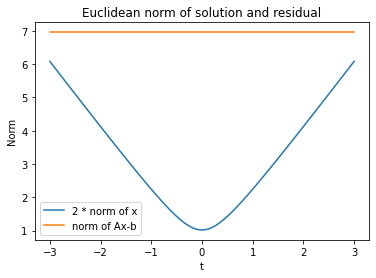

In [9]:
t = np.linspace(-3, 3, 100)  # free parameter
# column vectos of x_lsq are least squares solutions
x_lsq = (x_exact + Vt.T[:, 0] * t.reshape(-1, 1)).T
x_norm = np.linalg.norm(x_lsq, axis=0)
lsq_norm = np.linalg.norm(A @ x_lsq - b.reshape(-1, 1), axis=0)

plt.plot(t, 2 * x_norm, label="2 * norm of x")
plt.plot(t, lsq_norm, label="norm of Ax-b")
plt.legend()
plt.xlabel("t")
plt.ylabel("Norm")
plt.title("Euclidean norm of solution and residual")
# plt.savefig("least_squares_solution_norms.png")

#### Tiny Perturbation of $b$

In [10]:
eps = 1e-10
print(f"x_exact = {x_exact}")
print_dict(solve_least_squares(A, b + eps))

x_exact = [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ]
{'gelsd': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'gelsy': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'lsmr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'lsqr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'normal_eq': [-0.12487 -0.41176  0.23093 -0.48548 -0.35104]}


/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/ipykernel_launcher.py:46: LinAlgWarning: Ill-conditioned matrix (rcond=3.30641e-17): result may not be accurate.


### Ill-conditioned System
We set the first singular value of `A_ill` to 1e-10. 

In [11]:
S[0, 0] = 1e-10
A = U @ S @ Vt

S_inv = np.copy(S.T)
S_inv[S_inv>0] = 1/S_inv[S_inv>0]

# Minimum Norm Solution
x_exact = Vt.T @ S_inv @ U.T @ b

print(f"x_exact = {x_exact}")
print_dict(solve_least_squares(A, b))

x_exact = [ 9.93195e+09 -4.75650e+10 -1.34911e+10 -2.08104e+10 -3.71960e+10]
{'gelsd': [ 9.93194e+09 -4.75650e+10 -1.34910e+10 -2.08104e+10 -3.71960e+10],
 'gelsy': [ 9.93196e+09 -4.75650e+10 -1.34911e+10 -2.08104e+10 -3.71961e+10],
 'lsmr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'lsqr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'normal_eq': [  48559.67679 -232557.57746  -65960.92822 -101747.66128 -181861.06429]}


/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/ipykernel_launcher.py:46: LinAlgWarning: Ill-conditioned matrix (rcond=4.60305e-17): result may not be accurate.


In [12]:
print(f"norm of x:\n"
      f"x_exact:   {norm(x_exact)}\n"
      f"lsqr:      {norm(x_solution['lsqr'])}\n"
      f"normal_eq: {norm(x_solution['normal_eq'])}\n"
     )
print(f"norm of Ax-b:\n"
      f"x_exact:   {norm(A @ x_exact - b)}\n"
      f"lsqr:      {norm(A @ x_solution['lsqr'] - b)}\n"
      f"normal_eq: {norm(A @ x_solution['normal_eq'] - b)}"
     )

norm of x:
x_exact:   66028022639.34349
lsqr:      0.5092520023062157
normal_eq: 0.993975690303498

norm of Ax-b:
x_exact:   2.1991587442017146
lsqr:      6.959403209201494
normal_eq: 6.959403209120507


In [13]:
# Warning stems from this. As good/bad as LSQR.
np.linalg.norm(A @ linalg.solve(A.T @ A, A.T @ b, assume_a='sym') - b)

/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/ipykernel_launcher.py:2: LinAlgWarning: Ill-conditioned matrix (rcond=4.60305e-17): result may not be accurate.
  


6.959372580561515

In [14]:
# We can increase the accuracy of iterative methods.
# Then we get the same as x_exact.
spla.lsqr(A, b, atol=1e-12)[0]

array([  27924.82063, -133735.44751,  -37931.59475,  -58511.52324,
       -104581.72517])

This time not a null space, but an almost null space.

In [15]:
A @ Vt.T[:p, :1] #@ np.ones(1)

array([[ 4.83499e-11],
       [-1.92080e-11],
       [-3.07160e-11],
       [ 1.64669e-11],
       [-4.54631e-11],
       [-3.48040e-11],
       [ 3.01233e-11],
       [-2.31151e-11],
       [ 2.58315e-11],
       [-2.62972e-11]])

In [16]:
linalg.svd(A, compute_uv=False)

array([5.e+00, 4.e+00, 3.e+00, 2.e+00, 1.e-10])

#### Tiny Perturbation of $b$

In [17]:
print(f"x_exact = {x_exact}")
print_dict(solve_least_squares(A, b + eps))

x_exact = [ 9.93195e+09 -4.75650e+10 -1.34911e+10 -2.08104e+10 -3.71960e+10]
{'gelsd': [ 9.93194e+09 -4.75650e+10 -1.34910e+10 -2.08104e+10 -3.71960e+10],
 'gelsy': [ 9.93196e+09 -4.75650e+10 -1.34911e+10 -2.08104e+10 -3.71961e+10],
 'lsmr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'lsqr': [-0.21233  0.00708  0.34973 -0.30223 -0.0235 ],
 'normal_eq': [  48559.68267 -232557.60563  -65960.93621 -101747.67361 -181861.08632]}


/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/ipykernel_launcher.py:46: LinAlgWarning: Ill-conditioned matrix (rcond=4.60305e-17): result may not be accurate.
